In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import polars as pl

In [9]:
np.random.seed(42)

In [10]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [11]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 13:
        return '5-12'
    return '13-22'

In [12]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
event_features =  ['checkpoint_click','cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
room_features = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
room_events = ['checkpoint_library',
 'map_click_library',
 'navigate_click_library',
 'notification_click_library',
 'notebook_click_library',
 'cutscene_click_library',
 'person_click_library',
 'observation_click_library',
 'object_hover_library',
 'map_hover_library',
 'object_click_library',
 'notebook_click_capitol_1',
 'cutscene_click_capitol_1',
 'person_click_capitol_1',
 'notification_click_capitol_1',
 'observation_click_capitol_1',
 'map_click_capitol_1',
 'navigate_click_capitol_1',
 'object_click_capitol_1',
 'checkpoint_capitol_1',
 'map_hover_capitol_1',
 'object_hover_capitol_1',
 'map_click_historicalsociety',
 'object_click_historicalsociety',
 'map_hover_historicalsociety',
 'person_click_historicalsociety',
 'notification_click_historicalsociety',
 'cutscene_click_historicalsociety',
 'observation_click_historicalsociety',
 'navigate_click_historicalsociety',
 'checkpoint_historicalsociety',
 'notebook_click_historicalsociety',
 'object_hover_historicalsociety',
 'person_click_flaghouse',
 'notebook_click_flaghouse',
 'observation_click_flaghouse',
 'map_hover_flaghouse',
 'checkpoint_flaghouse',
 'notification_click_flaghouse',
 'map_click_flaghouse',
 'object_hover_flaghouse',
 'object_click_flaghouse',
 'cutscene_click_flaghouse',
 'navigate_click_flaghouse',
 'map_click_wildlife',
 'notification_click_wildlife',
 'cutscene_click_wildlife',
 'map_hover_wildlife',
 'checkpoint_wildlife',
 'object_click_wildlife',
 'observation_click_wildlife',
 'navigate_click_wildlife',
 'object_hover_wildlife',
 'person_click_wildlife',
 'notebook_click_wildlife',
 'checkpoint_drycleaner',
 'observation_click_drycleaner',
 'person_click_drycleaner',
 'notebook_click_drycleaner',
 'map_hover_drycleaner',
 'map_click_drycleaner',
 'object_hover_drycleaner',
 'cutscene_click_drycleaner',
 'notification_click_drycleaner',
 'navigate_click_drycleaner',
 'object_click_drycleaner',
 'navigate_click_capitol_2',
 'object_hover_capitol_2',
 'object_click_capitol_2',
 'cutscene_click_capitol_2',
 'observation_click_capitol_2',
 'notebook_click_capitol_2',
 'checkpoint_capitol_2',
 'notification_click_capitol_2',
 'person_click_capitol_2',
 'map_hover_capitol_2',
 'map_click_capitol_2',
 'cutscene_click_humanecology',
 'checkpoint_humanecology',
 'map_hover_humanecology',
 'object_hover_humanecology',
 'observation_click_humanecology',
 'notebook_click_humanecology',
 'map_click_humanecology',
 'navigate_click_humanecology',
 'person_click_humanecology',
 'notification_click_humanecology',
 'object_click_humanecology',
 'cutscene_click_capitol_0',
 'notebook_click_capitol_0',
 'checkpoint_capitol_0',
 'navigate_click_capitol_0',
 'object_hover_capitol_0',
 'map_click_capitol_0',
 'person_click_capitol_0',
 'object_click_capitol_0',
 'observation_click_capitol_0',
 'map_hover_capitol_0',
 'notification_click_capitol_0',
 'object_click_kohlcenter',
 'observation_click_kohlcenter',
 'notebook_click_kohlcenter',
 'person_click_kohlcenter',
 'notification_click_kohlcenter',
 'checkpoint_kohlcenter',
 'map_click_kohlcenter',
 'cutscene_click_kohlcenter',
 'object_hover_kohlcenter',
 'navigate_click_kohlcenter',
 'map_hover_kohlcenter']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [13]:
columns = [
    (pl.col('level') - pl.col('level').shift(1)).over('session_id','level_group').alias('level_shift'),
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col('room_fqid').str.split('.').arr[1].alias('main_room')
]

In [14]:
df = (pl.read_csv(Config.TRAIN_PATH)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

In [15]:
df=df.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 23), (8844238, 23), (13471703, 23))

In [16]:
del df
gc.collect()

5

In [17]:
level_limit = {'0-4':(1,5),'5-12':(5,13),'13-22':(13,23)}

In [18]:
def feature_engineer(x, grp, use_extra):
    aggs = [
          pl.col("index").count().alias(f"session_number"),
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
    pl.col('level_shift').min().alias('level_shift_min'),
    pl.col('level_shift').apply(lambda x: x < 0).count().alias('n_level_shift_negative'),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in range(0,23)],
    # *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique") for c in CATS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
    (pl.col('hover_duration').mean()
     .alias(f"hover_duration_mean")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
    (pl.col('elapsed_time_diff').quantile(0.1, "nearest")
     .alias(f"elapsed_time_diff_q1")),
    (pl.col('elapsed_time_diff').quantile(0.2, "nearest")
     .alias(f"elapsed_time_diff_q2")),
    (pl.col('elapsed_time_diff').quantile(0.3, "nearest")
     .alias(f"elapsed_time_diff_q3")),
    (pl.col('elapsed_time_diff').quantile(0.4, "nearest")
     .alias(f"elapsed_time_diff_q4")),
    (pl.col('elapsed_time_diff').quantile(0.6, "nearest")
     .alias(f"elapsed_time_diff_q6")),
    (pl.col('elapsed_time_diff').quantile(0.7, "nearest")
     .alias(f"elapsed_time_diff_q7")),
    (pl.col('elapsed_time_diff').quantile(0.8, "nearest")
     .alias(f"elapsed_time_diff_q8")),
    (pl.col('elapsed_time_diff').quantile(0.9, "nearest")
     .alias(f"elapsed_time_diff_q9")),
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in room_events],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in event_features ],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in fqid_lists ],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in fqid_lists],
    
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in text_lists ],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in text_lists],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]   
]                         
    a, b =level_limit[grp]

    for l in range(a,b):
        for c in event_features:
            aggs.append(pl.col("index").filter((pl.col("event_name")==c) & (pl.col('level')==l)).count().alias(f'{c}_level_{l}_count'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.max(np.diff(x))).alias(f'ET_between_{c}_level_{l}_max'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.min(np.diff(x))).alias(f'ET_between_{c}_level_{l}_min'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.mean(np.diff(x))).alias(f'ET_between_{c}_level_{l}_mean'))
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:
                
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [19]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=False)
print('df1 done',df1.shape)
df2 = feature_engineer(df2, grp='5-12', use_extra=False)
print('df2 done',df2.shape)
df3 = feature_engineer(df3, grp='13-22', use_extra=False)
print('df3 done',df3.shape)

df1 done (23562, 4051)
df2 done (23562, 4227)
df3 done (23562, 4315)
CPU times: total: 16min 33s
Wall time: 8min 41s


In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [23]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

2471 1944 1723
word_found
word_wells
word_Oh
word_flag
duration_level_5
duration_level_6
duration_level_7
duration_level_8
duration_level_9
duration_level_10
duration_level_11
duration_level_12
duration_level_13
duration_level_14
duration_level_15
duration_level_16
duration_level_17
duration_level_18
duration_level_19
duration_level_20
duration_level_21
duration_level_22
elapsed_time_diff_min
checkpoint_library_room_event_counts
map_click_library_room_event_counts
navigate_click_library_room_event_counts
notification_click_library_room_event_counts
notebook_click_library_room_event_counts
cutscene_click_library_room_event_counts
person_click_library_room_event_counts
observation_click_library_room_event_counts
object_hover_library_room_event_counts
map_hover_library_room_event_counts
object_click_library_room_event_counts
notebook_click_capitol_1_room_event_counts
cutscene_click_capitol_1_room_event_counts
person_click_capitol_1_room_event_counts
notification_click_capitol_1_room_event

In [24]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 1212 1955 2303 features
We will train with 23562 users info


In [25]:
df1.columns = [x + '_df1' for x in df1.columns]
df2.columns = [x + '_df2' for x in df2.columns]
df3.columns = [x + '_df3' for x in df3.columns]
FEATURES1 = [x + '_df1' for x in FEATURES1]
FEATURES2 = [x + '_df2' for x in FEATURES2]
FEATURES3 = [x + '_df3' for x in FEATURES3]


In [35]:
df4 = pd.concat([df1,df2], axis=1)
FEATURES4 = FEATURES1 + FEATURES2

In [34]:
df2.shape

(23562, 4232)

In [26]:
targets = pd.read_csv(Config.TRAIN_LABELS)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [27]:
from collections import defaultdict
from catboost import CatBoostClassifier

In [36]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df4
        FEATURES = FEATURES4
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.015,
        'alpha': 8,
        'max_depth': 6,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # clf = CatBoostClassifier(n_estimators=2000,random_state=42,learning_rate=0.02, max_depth=4, colsample_bylevel=0.5,devices='gpu')
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=100)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 1212
#########################
[0]	validation_0-logloss:0.68880
[100]	validation_0-logloss:0.52833
[200]	validation_0-logloss:0.50597
[300]	validation_0-logloss:0.50081
[400]	validation_0-logloss:0.49907
[500]	validation_0-logloss:0.49846
[600]	validation_0-logloss:0.49825
[700]	validation_0-logloss:0.49799
[781]	validation_0-logloss:0.49832
1 , [0]	validation_0-logloss:0.68873
[100]	validation_0-logloss:0.51827
[200]	validation_0-logloss:0.49361
[300]	validation_0-logloss:0.48831
[400]	validation_0-logloss:0.48670
[500]	validation_0-logloss:0.48631
[562]	validation_0-logloss:0.48628
2 , [0]	validation_0-logloss:0.68865
[100]	validation_0-logloss:0.52188
[200]	validation_0-logloss:0.49801
[300]	validation_0-logloss:0.49186
[400]	validation_0-logloss:0.49052
[500]	validation_0-logloss:0.48953
[600]	validation_0-logloss:0.48922
[700]	validation_0-logloss:0.48928
[751]	validation_0-logloss:0.48929
3 , [0]	validation_0-logloss:0.68875


,mean
feature,
object_click_kohlcenter_room_event_counts_df1,0.010174
elapsed_time_diff_cs_q4_df1,0.009648
plaque_fqid_counts_df1,0.008404
object_click/(object_click+notification_click)_df1,0.008326
elapsed_time_diff_cutscene_click_q4_df1,0.007622
elapsed_time_diff_cutscene_click_q6_df1,0.005648
elapsed_time_diff_chap1_finale_c_q9_df1,0.005557
elapsed_time_diff_tunic.historicalsociety.collection.cs_q4_df1,0.005428
elapsed_time_diff_chap1_finale_c_max_df1,0.004822


#########################
### question 2 with features 1212
#########################
[0]	validation_0-logloss:0.67957
[100]	validation_0-logloss:0.17900
[200]	validation_0-logloss:0.10834
[300]	validation_0-logloss:0.09646
[400]	validation_0-logloss:0.09503
[470]	validation_0-logloss:0.09523
1 , [0]	validation_0-logloss:0.67946
[100]	validation_0-logloss:0.17201
[200]	validation_0-logloss:0.09917
[300]	validation_0-logloss:0.08664
[400]	validation_0-logloss:0.08468
[500]	validation_0-logloss:0.08486
[533]	validation_0-logloss:0.08491
2 , [0]	validation_0-logloss:0.67949
[100]	validation_0-logloss:0.17386
[200]	validation_0-logloss:0.10083
[300]	validation_0-logloss:0.08805
[400]	validation_0-logloss:0.08576
[500]	validation_0-logloss:0.08545
[571]	validation_0-logloss:0.08559
3 , [0]	validation_0-logloss:0.67948
[100]	validation_0-logloss:0.17421
[200]	validation_0-logloss:0.10169
[300]	validation_0-logloss:0.08907
[400]	validation_0-logloss:0.08655
[500]	validation_0-logloss:0.08618


,mean
feature,
object_click_event_counts_df1,0.004622
object_click/(object_click+checkpoint_click)_df1,0.004380
elapsed_time_diff_tunic.historicalsociety.collection.gramps.found_q4_df1,0.003924
elapsed_time_diff_tunic.historicalsociety.collection.gramps.found_q3_df1,0.003722
word_median_it_df1,0.003157
elapsed_time_diff_chap1_finale_c_q6_df1,0.002926
elapsed_time_diff_cutscene_click_q6_df1,0.002890
duration_level_4_df1,0.002874
word_median_the_df1,0.002632


#########################
### question 3 with features 1212
#########################
[0]	validation_0-logloss:0.68189
[100]	validation_0-logloss:0.27558
[200]	validation_0-logloss:0.22485
[300]	validation_0-logloss:0.21726
[400]	validation_0-logloss:0.21553
[500]	validation_0-logloss:0.21503
[583]	validation_0-logloss:0.21548
1 , [0]	validation_0-logloss:0.68188
[100]	validation_0-logloss:0.27525
[200]	validation_0-logloss:0.22376
[300]	validation_0-logloss:0.21476
[400]	validation_0-logloss:0.21274
[500]	validation_0-logloss:0.21236
[600]	validation_0-logloss:0.21235
[658]	validation_0-logloss:0.21261
2 , [0]	validation_0-logloss:0.68181
[100]	validation_0-logloss:0.27027
[200]	validation_0-logloss:0.21835
[300]	validation_0-logloss:0.20955
[400]	validation_0-logloss:0.20748
[500]	validation_0-logloss:0.20673
[600]	validation_0-logloss:0.20661
[681]	validation_0-logloss:0.20681
3 , [0]	validation_0-logloss:0.68185
[100]	validation_0-logloss:0.27681
[200]	validation_0-logloss:0.22858


,mean
feature,
object_click_event_counts_df1,0.005730
object_click/(object_click+checkpoint_click)_df1,0.004957
word_mean_you_df1,0.003105
object_click/(object_click+notification_click)_df1,0.002945
elapsed_time_diff_chap1_finale_c_q8_df1,0.002757
elapsed_time_diff_chap1_finale_c_q9_df1,0.002684
elapsed_time_diff_chap1_finale_c_max_df1,0.002678
text_fqid_null_df1,0.002623
n_level_shift_negative_df1,0.002424


#########################
### question 4 with features 3167
#########################
[0]	validation_0-logloss:0.68651
[100]	validation_0-logloss:0.44663
[200]	validation_0-logloss:0.41809
[300]	validation_0-logloss:0.41347
[400]	validation_0-logloss:0.41265
[500]	validation_0-logloss:0.41272
[541]	validation_0-logloss:0.41279
1 , [0]	validation_0-logloss:0.68654
[100]	validation_0-logloss:0.45300
[200]	validation_0-logloss:0.42708
[300]	validation_0-logloss:0.42266
[400]	validation_0-logloss:0.42202
[477]	validation_0-logloss:0.42199
2 , [0]	validation_0-logloss:0.68634
[100]	validation_0-logloss:0.44406
[200]	validation_0-logloss:0.41563
[300]	validation_0-logloss:0.41146
[400]	validation_0-logloss:0.41040
[500]	validation_0-logloss:0.40979
[600]	validation_0-logloss:0.40932
[700]	validation_0-logloss:0.40939
[733]	validation_0-logloss:0.40953
3 , [0]	validation_0-logloss:0.68651
[100]	validation_0-logloss:0.44509
[200]	validation_0-logloss:0.41610
[300]	validation_0-logloss:0.41101


,mean
feature,
elapsed_time_diff_person_click_q3_df2,0.018546
elapsed_time_diff_worker_q3_df2,0.016945
elapsed_time_diff_person_click_q2_df2,0.016332
elapsed_time_diff_person_click_q4_df2,0.009358
elapsed_time_diff_tunic.drycleaner.frontdesk.worker.hub_q3_df2,0.008596
elapsed_time_diff_worker_q4_df2,0.006084
elapsed_time_diff_tunic.library.frontdesk.worker.wells_q3_df2,0.005720
n_level_shift_negative_df2,0.004428
elapsed_time_diff_tunic.library.frontdesk.worker.wells_q4_df2,0.004415


#########################
### question 5 with features 3167
#########################
[0]	validation_0-logloss:0.69140
[100]	validation_0-logloss:0.62496
[200]	validation_0-logloss:0.61223
[300]	validation_0-logloss:0.60748
[400]	validation_0-logloss:0.60497
[500]	validation_0-logloss:0.60362
[600]	validation_0-logloss:0.60302
[700]	validation_0-logloss:0.60302
[721]	validation_0-logloss:0.60307
1 , [0]	validation_0-logloss:0.69153
[100]	validation_0-logloss:0.62955
[200]	validation_0-logloss:0.61885
[300]	validation_0-logloss:0.61532
[400]	validation_0-logloss:0.61397
[500]	validation_0-logloss:0.61323
[600]	validation_0-logloss:0.61264
[690]	validation_0-logloss:0.61281
2 , [0]	validation_0-logloss:0.69166
[100]	validation_0-logloss:0.63039
[200]	validation_0-logloss:0.61978
[300]	validation_0-logloss:0.61656
[400]	validation_0-logloss:0.61521
[500]	validation_0-logloss:0.61449
[600]	validation_0-logloss:0.61447
[634]	validation_0-logloss:0.61451
3 , [0]	validation_0-logloss:0.69156


,mean
feature,
n_level_shift_negative_df2,0.008868
text_fqid_null_df2,0.007689
session_number_df2,0.006680
elapsed_time_diff_worker_q2_df2,0.003283
elapsed_time_diff_worker_q3_df2,0.003246
elapsed_time_diff_tunic.humanecology.frontdesk.worker.intro_q2_df2,0.002878
elapsed_time_diff_tunic.humanecology.frontdesk.worker.intro_q3_df2,0.002571
word_the_df2,0.002128
navigate_click_event_counts_df2,0.002124


#########################
### question 6 with features 3167
#########################
[0]	validation_0-logloss:0.68760
[100]	validation_0-logloss:0.49394
[200]	validation_0-logloss:0.47077
[300]	validation_0-logloss:0.46560
[400]	validation_0-logloss:0.46367
[500]	validation_0-logloss:0.46230
[600]	validation_0-logloss:0.46137
[700]	validation_0-logloss:0.46087
[800]	validation_0-logloss:0.46049
[900]	validation_0-logloss:0.46029
[969]	validation_0-logloss:0.46032
1 , [0]	validation_0-logloss:0.68771
[100]	validation_0-logloss:0.49762
[200]	validation_0-logloss:0.47552
[300]	validation_0-logloss:0.47020
[400]	validation_0-logloss:0.46842
[500]	validation_0-logloss:0.46782
[600]	validation_0-logloss:0.46758
[685]	validation_0-logloss:0.46798
2 , [0]	validation_0-logloss:0.68764
[100]	validation_0-logloss:0.49373
[200]	validation_0-logloss:0.47305
[300]	validation_0-logloss:0.46910
[400]	validation_0-logloss:0.46788
[500]	validation_0-logloss:0.46750
[600]	validation_0-logloss:0.46752
[6

,mean
feature,
n_level_shift_negative_df2,0.009055
text_fqid_null_df2,0.006993
session_number_df2,0.006972
map_click/(map_click+checkpoint_click)_df2,0.003698
journals.pic_1.next_fqid_counts_df2,0.002361
navigate_click_level_11_count_df2,0.002035
word_to_df2,0.001517
duration_level_11_df2,0.001466
word_the_df2,0.001466


#########################
### question 7 with features 3167
#########################
[0]	validation_0-logloss:0.68921
[100]	validation_0-logloss:0.55222
[200]	validation_0-logloss:0.53740
[300]	validation_0-logloss:0.53377
[400]	validation_0-logloss:0.53274
[499]	validation_0-logloss:0.53290
1 , [0]	validation_0-logloss:0.68912
[100]	validation_0-logloss:0.54551
[200]	validation_0-logloss:0.52867
[300]	validation_0-logloss:0.52506
[400]	validation_0-logloss:0.52387
[500]	validation_0-logloss:0.52357
[529]	validation_0-logloss:0.52347
2 , [0]	validation_0-logloss:0.68888
[100]	validation_0-logloss:0.53250
[200]	validation_0-logloss:0.51191
[300]	validation_0-logloss:0.50658
[400]	validation_0-logloss:0.50437
[500]	validation_0-logloss:0.50358
[600]	validation_0-logloss:0.50338
[651]	validation_0-logloss:0.50338
3 , [0]	validation_0-logloss:0.68906
[100]	validation_0-logloss:0.54633
[200]	validation_0-logloss:0.52970
[300]	validation_0-logloss:0.52516
[400]	validation_0-logloss:0.52334


,mean
feature,
n_level_shift_negative_df2,0.006618
text_fqid_null_df2,0.005852
session_number_df2,0.005168
map_click/(map_click+checkpoint_click)_df2,0.003488
elapsed_time_diff_person_click_q2_df2,0.002995
elapsed_time_diff_worker_q2_df2,0.001837
elapsed_time_diff_cutscene_click_q2_df1,0.001753
navigate_click_level_11_count_df2,0.001742
map_click/(map_click+notification_click)_df2,0.001632


#########################
### question 8 with features 3167
#########################
[0]	validation_0-logloss:0.69192
[100]	validation_0-logloss:0.64774
[200]	validation_0-logloss:0.64291
[300]	validation_0-logloss:0.64276
[330]	validation_0-logloss:0.64258
1 , [0]	validation_0-logloss:0.69205
[100]	validation_0-logloss:0.65281
[200]	validation_0-logloss:0.64900
[300]	validation_0-logloss:0.64896
[344]	validation_0-logloss:0.64922
2 , [0]	validation_0-logloss:0.69198
[100]	validation_0-logloss:0.65125
[200]	validation_0-logloss:0.64710
[300]	validation_0-logloss:0.64737
[325]	validation_0-logloss:0.64761
3 , [0]	validation_0-logloss:0.69201
[100]	validation_0-logloss:0.64999
[200]	validation_0-logloss:0.64517
[300]	validation_0-logloss:0.64425
[400]	validation_0-logloss:0.64391
[500]	validation_0-logloss:0.64465
[502]	validation_0-logloss:0.64469
4 , [0]	validation_0-logloss:0.69198
[100]	validation_0-logloss:0.64888
[200]	validation_0-logloss:0.64372
[300]	validation_0-logloss:0.6429

,mean
feature,
text_fqid_null_df2,0.003895
n_level_shift_negative_df2,0.003783
object_click/(object_click+checkpoint_click)_df2,0.003000
object_click_event_counts_df2,0.002812
session_number_df2,0.002778
elapsed_time_diff_tunic.drycleaner.frontdesk.worker.hub_q4_df2,0.001420
word_the_df2,0.001377
object_click/(object_click+cutscene_click)_df2,0.001247
map_click_event_counts_df2,0.001242


#########################
### question 9 with features 3167
#########################
[0]	validation_0-logloss:0.68897
[100]	validation_0-logloss:0.54057
[200]	validation_0-logloss:0.52237
[300]	validation_0-logloss:0.51844
[400]	validation_0-logloss:0.51698
[500]	validation_0-logloss:0.51612
[600]	validation_0-logloss:0.51584
[693]	validation_0-logloss:0.51644
1 , [0]	validation_0-logloss:0.68904
[100]	validation_0-logloss:0.54583
[200]	validation_0-logloss:0.52959
[300]	validation_0-logloss:0.52666
[400]	validation_0-logloss:0.52626
[500]	validation_0-logloss:0.52574
[600]	validation_0-logloss:0.52619
[619]	validation_0-logloss:0.52625
2 , [0]	validation_0-logloss:0.68891
[100]	validation_0-logloss:0.53655
[200]	validation_0-logloss:0.51978
[300]	validation_0-logloss:0.51629
[400]	validation_0-logloss:0.51485
[500]	validation_0-logloss:0.51404
[600]	validation_0-logloss:0.51320
[700]	validation_0-logloss:0.51288
[800]	validation_0-logloss:0.51262
[877]	validation_0-logloss:0.51279
3 

,mean
feature,
n_level_shift_negative_df2,0.008864
text_fqid_null_df2,0.008423
session_number_df2,0.007144
word_to_df2,0.003526
word_the_df2,0.002622
journals.pic_1.next_fqid_counts_df2,0.001738
elapsed_time_diff_tunic.historicalsociety.collection.cs_q4_df1,0.001727
map_hover_kohlcenter_room_event_counts_df2,0.001474
navigate_click_level_11_count_df2,0.001450


#########################
### question 10 with features 3167
#########################
[0]	validation_0-logloss:0.69208
[100]	validation_0-logloss:0.64590
[200]	validation_0-logloss:0.63719
[300]	validation_0-logloss:0.63453
[400]	validation_0-logloss:0.63355
[500]	validation_0-logloss:0.63314
[600]	validation_0-logloss:0.63281
[643]	validation_0-logloss:0.63295
1 , [0]	validation_0-logloss:0.69206
[100]	validation_0-logloss:0.64552
[200]	validation_0-logloss:0.63731
[300]	validation_0-logloss:0.63489
[400]	validation_0-logloss:0.63399
[500]	validation_0-logloss:0.63355
[600]	validation_0-logloss:0.63340
[664]	validation_0-logloss:0.63385
2 , [0]	validation_0-logloss:0.69202
[100]	validation_0-logloss:0.64256
[200]	validation_0-logloss:0.63353
[300]	validation_0-logloss:0.63104
[400]	validation_0-logloss:0.63041
[478]	validation_0-logloss:0.63079
3 , [0]	validation_0-logloss:0.69215
[100]	validation_0-logloss:0.65282
[200]	validation_0-logloss:0.64783
[300]	validation_0-logloss:0.64649

,mean
feature,
n_level_shift_negative_df2,0.008176
session_number_df2,0.006269
text_fqid_null_df2,0.006196
object_click_event_counts_df2,0.003146
object_click/(object_click+checkpoint_click)_df2,0.002500
object_click_level_11_count_df2,0.002073
word_Jo_df1,0.001756
elapsed_time_diff_person_click_q1_df2,0.001746
elapsed_time_diff_person_click_q2_df2,0.001518


#########################
### question 11 with features 3167
#########################
[0]	validation_0-logloss:0.69131
[100]	validation_0-logloss:0.62936
[200]	validation_0-logloss:0.62285
[300]	validation_0-logloss:0.62204
[400]	validation_0-logloss:0.62225
[418]	validation_0-logloss:0.62225
1 , [0]	validation_0-logloss:0.69125
[100]	validation_0-logloss:0.62180
[200]	validation_0-logloss:0.61226
[300]	validation_0-logloss:0.60961
[400]	validation_0-logloss:0.60894
[500]	validation_0-logloss:0.60865
[543]	validation_0-logloss:0.60863
2 , [0]	validation_0-logloss:0.69116
[100]	validation_0-logloss:0.62353
[200]	validation_0-logloss:0.61580
[300]	validation_0-logloss:0.61410
[400]	validation_0-logloss:0.61420
[452]	validation_0-logloss:0.61413
3 , [0]	validation_0-logloss:0.69131
[100]	validation_0-logloss:0.62534
[200]	validation_0-logloss:0.61772
[300]	validation_0-logloss:0.61597
[400]	validation_0-logloss:0.61583
[472]	validation_0-logloss:0.61593
4 , [0]	validation_0-logloss:0.691

,mean
feature,
n_level_shift_negative_df2,0.005907
text_fqid_null_df2,0.005722
session_number_df2,0.005075
object_click_event_counts_df2,0.003905
object_click/(object_click+checkpoint_click)_df2,0.003467
object_click/(object_click+notification_click)_df2,0.002684
object_click_level_11_count_df2,0.001782
duration_level_11_df2,0.001331
map_click/(map_click+checkpoint_click)_df2,0.001220


#########################
### question 12 with features 3167
#########################
[0]	validation_0-logloss:0.68511
[100]	validation_0-logloss:0.40655
[200]	validation_0-logloss:0.37958
[300]	validation_0-logloss:0.37628
[400]	validation_0-logloss:0.37575
[491]	validation_0-logloss:0.37659
1 , [0]	validation_0-logloss:0.68500
[100]	validation_0-logloss:0.39798
[200]	validation_0-logloss:0.36794
[300]	validation_0-logloss:0.36368
[400]	validation_0-logloss:0.36271
[500]	validation_0-logloss:0.36245
[585]	validation_0-logloss:0.36254
2 , [0]	validation_0-logloss:0.68518
[100]	validation_0-logloss:0.41012
[200]	validation_0-logloss:0.38710
[300]	validation_0-logloss:0.38591
[364]	validation_0-logloss:0.38626
3 , [0]	validation_0-logloss:0.68505
[100]	validation_0-logloss:0.40361
[200]	validation_0-logloss:0.37679
[300]	validation_0-logloss:0.37364
[396]	validation_0-logloss:0.37363
4 , [0]	validation_0-logloss:0.68518
[100]	validation_0-logloss:0.40999
[200]	validation_0-logloss:0.385

,mean
feature,
n_level_shift_negative_df2,0.003118
text_fqid_null_df2,0.003014
session_number_df2,0.002748
navigate_click/(navigate_click+checkpoint_click)_df2,0.002386
navigate_click_event_counts_df2,0.002014
map_click_event_counts_df2,0.001386
navigate_click_level_11_count_df2,0.001360
elapsed_time_diff_report_mean_df1,0.001282
map_click/(map_click+checkpoint_click)_df2,0.001191


#########################
### question 13 with features 3167
#########################
[0]	validation_0-logloss:0.68912
[100]	validation_0-logloss:0.54829
[200]	validation_0-logloss:0.53116
[300]	validation_0-logloss:0.52666
[400]	validation_0-logloss:0.52484
[500]	validation_0-logloss:0.52423
[600]	validation_0-logloss:0.52381
[700]	validation_0-logloss:0.52371
[748]	validation_0-logloss:0.52397
1 , [0]	validation_0-logloss:0.68945
[100]	validation_0-logloss:0.56631
[200]	validation_0-logloss:0.55546
[300]	validation_0-logloss:0.55296
[400]	validation_0-logloss:0.55236
[500]	validation_0-logloss:0.55184
[600]	validation_0-logloss:0.55164
[658]	validation_0-logloss:0.55158
2 , [0]	validation_0-logloss:0.68941
[100]	validation_0-logloss:0.56201
[200]	validation_0-logloss:0.54912
[300]	validation_0-logloss:0.54639
[400]	validation_0-logloss:0.54486
[500]	validation_0-logloss:0.54466
[573]	validation_0-logloss:0.54506
3 , [0]	validation_0-logloss:0.68919
[100]	validation_0-logloss:0.54472

,mean
feature,
object_click/(object_click+cutscene_click)_df2,0.007222
object_click/(object_click+checkpoint_click)_df2,0.006689
cutscene_click/(cutscene_click+object_click)_df2,0.006157
object_click/(object_click+notification_click)_df2,0.005669
object_click_event_counts_df2,0.005233
notification_click/(notification_click+object_click)_df2,0.004380
object_click/(object_click+person_click)_df2,0.002829
object_click_historicalsociety_room_event_counts_df2,0.002060
ET_between_object_hover_level_11_max_df2,0.001741


#########################
### question 14 with features 2303
#########################
[0]	validation_0-logloss:0.68961
[100]	validation_0-logloss:0.56110
[200]	validation_0-logloss:0.54589
[300]	validation_0-logloss:0.54298
[400]	validation_0-logloss:0.54218
[500]	validation_0-logloss:0.54185
[583]	validation_0-logloss:0.54196
1 , [0]	validation_0-logloss:0.68959
[100]	validation_0-logloss:0.56211
[200]	validation_0-logloss:0.54848
[300]	validation_0-logloss:0.54714
[400]	validation_0-logloss:0.54643
[500]	validation_0-logloss:0.54587
[600]	validation_0-logloss:0.54627
[607]	validation_0-logloss:0.54627
2 , [0]	validation_0-logloss:0.68948
[100]	validation_0-logloss:0.55682
[200]	validation_0-logloss:0.53979
[300]	validation_0-logloss:0.53608
[400]	validation_0-logloss:0.53487
[493]	validation_0-logloss:0.53493
3 , [0]	validation_0-logloss:0.68973
[100]	validation_0-logloss:0.57111
[200]	validation_0-logloss:0.55948
[300]	validation_0-logloss:0.55709
[400]	validation_0-logloss:0.55632

,mean
feature,
n_level_shift_negative_df3,0.011223
word_to_df3,0.010790
text_fqid_null_df3,0.009693
session_number_df3,0.008687
notification_click_level_15_count_df3,0.005018
map_click_event_counts_df3,0.003311
map_click/(map_click+checkpoint_click)_df3,0.003133
tocloset_dirty_fqid_counts_df3,0.003112
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts_df3,0.002847


#########################
### question 15 with features 2303
#########################
[0]	validation_0-logloss:0.69181
[100]	validation_0-logloss:0.62897
[200]	validation_0-logloss:0.61599
[300]	validation_0-logloss:0.61239
[400]	validation_0-logloss:0.61179
[500]	validation_0-logloss:0.61184
[600]	validation_0-logloss:0.61141
[693]	validation_0-logloss:0.61170
1 , [0]	validation_0-logloss:0.69166
[100]	validation_0-logloss:0.63227
[200]	validation_0-logloss:0.62071
[300]	validation_0-logloss:0.61754
[400]	validation_0-logloss:0.61651
[500]	validation_0-logloss:0.61593
[560]	validation_0-logloss:0.61584
2 , [0]	validation_0-logloss:0.69183
[100]	validation_0-logloss:0.63198
[200]	validation_0-logloss:0.62006
[300]	validation_0-logloss:0.61688
[400]	validation_0-logloss:0.61566
[500]	validation_0-logloss:0.61539
[596]	validation_0-logloss:0.61544
3 , [0]	validation_0-logloss:0.69175
[100]	validation_0-logloss:0.63150
[200]	validation_0-logloss:0.62049
[300]	validation_0-logloss:0.61734

,mean
feature,
word_to_df3,0.014476
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q3_df3,0.008440
notification_click_level_15_count_df3,0.006855
n_level_shift_negative_df3,0.006361
session_number_df3,0.004964
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q4_df3,0.004018
flag_girl_fqid_counts_df3,0.003664
text_fqid_null_df3,0.003515
person_click_level_20_count_df3,0.003346


#########################
### question 16 with features 2303
#########################
[0]	validation_0-logloss:0.68982
[100]	validation_0-logloss:0.58309
[200]	validation_0-logloss:0.57554
[300]	validation_0-logloss:0.57404
[400]	validation_0-logloss:0.57350
[499]	validation_0-logloss:0.57363
1 , [0]	validation_0-logloss:0.68961
[100]	validation_0-logloss:0.56413
[200]	validation_0-logloss:0.55119
[300]	validation_0-logloss:0.54847
[400]	validation_0-logloss:0.54770
[500]	validation_0-logloss:0.54709
[590]	validation_0-logloss:0.54748
2 , [0]	validation_0-logloss:0.68975
[100]	validation_0-logloss:0.57598
[200]	validation_0-logloss:0.56655
[300]	validation_0-logloss:0.56543
[400]	validation_0-logloss:0.56459
[500]	validation_0-logloss:0.56472
[529]	validation_0-logloss:0.56491
3 , [0]	validation_0-logloss:0.68977
[100]	validation_0-logloss:0.58059
[200]	validation_0-logloss:0.57280
[300]	validation_0-logloss:0.57267
[333]	validation_0-logloss:0.57265
4 , [0]	validation_0-logloss:0.689

,mean
feature,
navigate_click/(navigate_click+notification_click)_df3,0.001688
elapsed_time_diff_person_click_q9_df3,0.001486
elapsed_time_diff_worker_q7_df3,0.001355
notification_click/(notification_click+navigate_click)_df3,0.001246
elapsed_time_diff_notification_click_q4_df3,0.001199
word_median_need_df3,0.001157
elapsed_time_diff_tunic.flaghouse.entry.colorbook_q6_df3,0.001084
n_level_shift_negative_df3,0.001052
navigate_click_level_19_count_df3,0.001020


#########################
### question 17 with features 2303
#########################
[0]	validation_0-logloss:0.69094
[100]	validation_0-logloss:0.62359
[200]	validation_0-logloss:0.61965
[293]	validation_0-logloss:0.61989
1 , [0]	validation_0-logloss:0.69089
[100]	validation_0-logloss:0.61207
[200]	validation_0-logloss:0.60569
[300]	validation_0-logloss:0.60518
[338]	validation_0-logloss:0.60525
2 , [0]	validation_0-logloss:0.69075
[100]	validation_0-logloss:0.60759
[200]	validation_0-logloss:0.59987
[300]	validation_0-logloss:0.59860
[400]	validation_0-logloss:0.59827
[459]	validation_0-logloss:0.59811
3 , [0]	validation_0-logloss:0.69081
[100]	validation_0-logloss:0.61195
[200]	validation_0-logloss:0.60656
[300]	validation_0-logloss:0.60645
[339]	validation_0-logloss:0.60656
4 , [0]	validation_0-logloss:0.69086
[100]	validation_0-logloss:0.61172
[200]	validation_0-logloss:0.60444
[300]	validation_0-logloss:0.60312
[400]	validation_0-logloss:0.60292
[473]	validation_0-logloss:0.603

,mean
feature,
duration_df3,0.004502
word_sum_flag_df3,0.003852
duration_level_19_df3,0.003074
ET_between_person_click_level_19_mean_df3,0.001912
word_mean_flag_df3,0.001746
duration_level_20_df3,0.001626
duration_level_21_df3,0.001458
elapsed_time_diff_journals_flag.pic_0.next_q9_df3,0.001188
navigate_click/(navigate_click+cutscene_click)_df3,0.001126


#########################
### question 18 with features 2303
#########################
[0]	validation_0-logloss:0.68108
[100]	validation_0-logloss:0.24461
[200]	validation_0-logloss:0.19103
[300]	validation_0-logloss:0.18323
[400]	validation_0-logloss:0.18244
[475]	validation_0-logloss:0.18261
1 , [0]	validation_0-logloss:0.68105
[100]	validation_0-logloss:0.23962
[200]	validation_0-logloss:0.18330
[300]	validation_0-logloss:0.17372
[400]	validation_0-logloss:0.17203
[500]	validation_0-logloss:0.17199
[511]	validation_0-logloss:0.17195
2 , [0]	validation_0-logloss:0.68105
[100]	validation_0-logloss:0.24088
[200]	validation_0-logloss:0.18598
[300]	validation_0-logloss:0.17763
[400]	validation_0-logloss:0.17637
[500]	validation_0-logloss:0.17636
[551]	validation_0-logloss:0.17659
3 , [0]	validation_0-logloss:0.68098
[100]	validation_0-logloss:0.23893
[200]	validation_0-logloss:0.18293
[300]	validation_0-logloss:0.17438
[400]	validation_0-logloss:0.17287
[500]	validation_0-logloss:0.17225

,mean
feature,
session_number_df3,0.002809
n_level_shift_negative_df3,0.002554
text_fqid_null_df3,0.002468
notification_click_level_15_count_df3,0.002098
ET_between_notebook_click_level_20_max_df3,0.002064
flag_girl_fqid_counts_df3,0.002033
notification_click/(notification_click+map_click)_df3,0.001987
ET_between_object_click_level_15_mean_df3,0.001905
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q3_df3,0.001896


CPU times: total: 1h 33min 52s
Wall time: 1h 18min 57s


In [37]:
importance_dict

{}

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

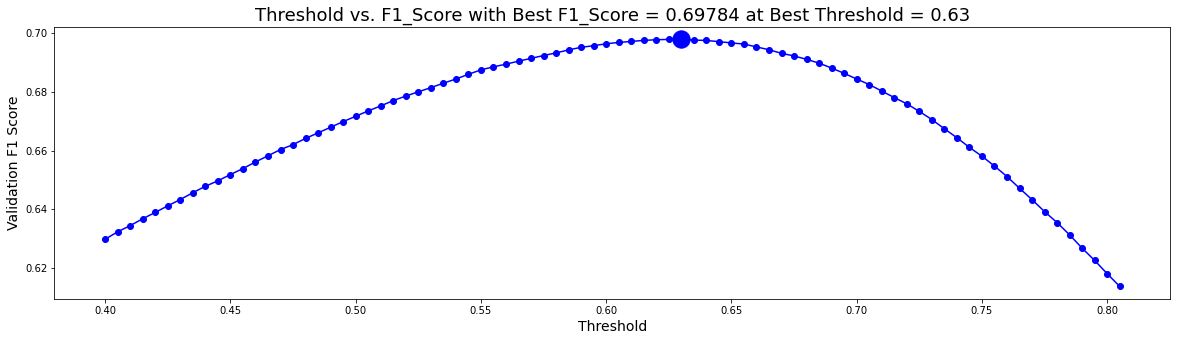

In [38]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [40]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df4
        FEATURES = FEATURES4
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.015,
        'alpha': 8,
        'max_depth': 6,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.json')
    
    print()

#########################
### question 1 features 1212

#########################
### question 2 features 1212

#########################
### question 3 features 1212

#########################
### question 4 features 3167

#########################
### question 5 features 3167

#########################
### question 6 features 3167

#########################
### question 7 features 3167

#########################
### question 8 features 3167

#########################
### question 9 features 3167

#########################
### question 10 features 3167

#########################
### question 11 features 3167

#########################
### question 12 features 3167

#########################
### question 13 features 3167

#########################
### question 14 features 2303

#########################
### question 15 features 2303

#########################
### question 16 features 2303

#########################
### question 17 features 2303

#########################
### question 1

In [41]:
import pickle

In [43]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES4
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [46]:
len(importance_dict['5'])

3167